<br><br>
<font size='6'><b>Autoencoder
</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 60% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 20%>
        By Prof. Seungchul Lee<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

# 1. Unsupervised Learning

__ Definition __
- Unsupervised learning refers to most attempts to extract information from a distribution that do not require human labor to annotate example
- Main task is to find the 'best' representation of the data

__ Dimension Reduction __
- Attempt to compress as much information about $x$ as possible in a smaller representation
- Preserve as much information about $x$ as possible while obeying some constraint aimed at keeping the representation simpler

<br>
<img src="./image_files/dim_reduction.png" width = 400>
<br>

# 2. Autoencoders

- It is like 'deep learning version' of unsupervised learning

__Definition__
- An autoencoder is a neural network that is trained to attempt to copy its input to its output
- The network consists of two parts: an encoder function and a decoder that produces a reconstruction

<br>
<img src="./image_files/autoencoder_before.png" width = 600>
<br>

<br>
<img src="./image_files/autoencoder_cat.png" width = 600>
<br>

__ Encoder and Decoder __
- Encoder function : $h = f(x)$
- Decoder function : $r = g(h)$
- We learn to set $g\left(f(x)\right) = x$

__ Modern Autoencoders __
- Beyond deterministic functions to stochastic mapping: $p_{\text{encoder}}(h\mid x)$ and $p_{\text{decoder}}(x\mid h)$
    - Variabtional autoencoder (VAE)
    - Generative adversarial nerwork (GAN)


- Will not cover them in this tutorial

<br>
<img src="./image_files/autoencoder_gaussian.png" width = 800>
<br>

# 3. Autoencoder with TensorFlow

- MNIST example
- Use only (1, 5, 6) digits to visualize in 2-D

<br>
<img src="./image_files/AE_arch2.png" width = 800>

## 3.1. Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 3.2. Load MNIST Data

In [2]:
def batch_maker(batch_size, img, label):
    img_len = len(img)
    random_idx = np.random.randint(img_len, size = batch_size)
    return img[random_idx], label[random_idx]

In [3]:
from six.moves import cPickle

mnist = cPickle.load(open('./data_files/MNIST.pkl', 'rb'))
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6))
test_idx = ((np.argmax(mnist.test.labels, 1) == 1) | \
            (np.argmax(mnist.test.labels, 1) == 5) | \
            (np.argmax(mnist.test.labels, 1) == 6))

train_imgs   = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
test_imgs    = mnist.test.images[test_idx]
test_labels  = mnist.test.labels[test_idx]
n_train      = train_imgs.shape[0]
n_test       = test_imgs.shape[0]
print ("Packages loaded")
print ("The number of trainimgs : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of testimgs : {}, shape : {}".format(n_test, test_imgs.shape))

Packages loaded
The number of trainimgs : 16583, shape : (16583, 784)
The number of testimgs : 2985, shape : (2985, 784)


## 3.3. Define an Autoencoder Shape
- Input shape and latent variable shape
- Encoder shape
- Decoder shape

In [4]:
# Shape of input and latent variable
n_input = 28*28

# Encoder shape
n_encoder1 = 500
n_encoder2 = 300

n_latent = 2

# Decoder shape
n_decoder1 = 300
n_decoder2 = 500

## 3.4. Define Weights and Biases
- Define weights and biases for encoder and decoder, separately
- Based on the predefied layer size
- Initialize with normal distribution with $\mu=0$ and $\sigma=0.01$

In [5]:
weights = {
    'encoder1' : tf.Variable(tf.random_normal([n_input, n_encoder1], stddev=0.1)),
    'encoder2' : tf.Variable(tf.random_normal([n_encoder1, n_encoder2], stddev=0.1)),
    'latent' : tf.Variable(tf.random_normal([n_encoder2, n_latent], stddev=0.1)),
    'decoder1' : tf.Variable(tf.random_normal([n_latent, n_decoder1], stddev=0.1)),
    'decoder2' : tf.Variable(tf.random_normal([n_decoder1, n_decoder2], stddev=0.1)),
    'reconst' : tf.Variable(tf.random_normal([n_decoder2, n_input], stddev=0.1))
}

biases = {
    'encoder1' : tf.Variable(tf.random_normal([n_encoder1], stddev=0.1)),
    'encoder2' : tf.Variable(tf.random_normal([n_encoder2], stddev=0.1)),
    'latent' : tf.Variable(tf.random_normal([n_latent], stddev=0.1)),
    'decoder1' : tf.Variable(tf.random_normal([n_decoder1], stddev=0.1)),
    'decoder2' : tf.Variable(tf.random_normal([n_decoder2], stddev=0.1)),
    'reconst' : tf.Variable(tf.random_normal([n_input], stddev=0.1))
}

## 3.5. Build a Model
__Encoder__
- Simple ANN (MLP) model
- Use $tanh$ for nonlinear activation function
- $latent$ is not applied with nonlinear activation function

__Decoder__
- Simple ANN (MLP) model
- Use $tanh$ for nonlinear activation function
- $reconst$ is not applied with nonlinear activation function

<br>
<img src="./image_files/autoencoder2.jpg" width = 700>

In [6]:
def encoder(x, weights, biases):
    encoder1 = tf.add(tf.matmul(x, weights['encoder1']), biases['encoder1'])
    encoder1 = tf.nn.tanh(encoder1)
    
    encoder2 = tf.add(tf.matmul(encoder1, weights['encoder2']), biases['encoder2'])
    encoder2 = tf.nn.tanh(encoder2)
    
    latent = tf.add(tf.matmul(encoder2, weights['latent']), biases['latent'])

    return latent

In [7]:
def decoder(latent, weights, biases):
    decoder1 = tf.add(tf.matmul(latent, weights['decoder1']), biases['decoder1'])
    decoder1 = tf.nn.tanh(decoder1)
    
    decoder2 = tf.add(tf.matmul(decoder1, weights['decoder2']), biases['decoder2'])
    decoder2 = tf.nn.tanh(decoder2)
    
    reconst = tf.add(tf.matmul(decoder2, weights['reconst']), biases['reconst'])
   
    return reconst

## 3.6. Define Loss, Initializer and Optimizer

__Loss__
- Squared loss
$$  \frac{1}{N}\sum_{i=1}^{N} (t_{i} - y_{i})^2 $$

__Initializer__
- Initialize all the empty variables
    
__Optimizer__
- AdamOptimizer: The most popular optimizer

In [8]:
LR = 0.0001
x = tf.placeholder(tf.float32, [None, n_input])

latent = encoder(x, weights, biases)
reconst = decoder(latent, weights, biases)
loss = tf.square(x - reconst)
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

## 3.7. Summary of Model

<img src="./image_files/rnn_summary of model.png" width = 500>

## 2.8. Define Configuration
- Define parameters for training autoencoder
     - n_batch : batch size for stochastic gradient descent
     - n_iter : the number of training steps
     - n_prt : check loss for every n_prt iteration

In [9]:
n_batch = 500
n_iter = 10000
n_prt = 500

## 2.9. Optimization

Do not run during the tutorial.

In [10]:
# Run initialize
config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
sess = tf.Session(config=config)
sess.run(init)

# Training cycle
for epoch in range(n_iter):
    train_x, train_y = batch_maker(n_batch, train_imgs, train_labels)
    sess.run(optm, feed_dict={x: train_x})  
    
    if epoch % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.4264843165874481
Iter : 500
Cost : 0.04356105625629425
Iter : 1000
Cost : 0.039353907108306885
Iter : 1500
Cost : 0.035449717193841934
Iter : 2000
Cost : 0.03336288034915924
Iter : 2500
Cost : 0.03329233452677727
Iter : 3000
Cost : 0.03269435837864876
Iter : 3500
Cost : 0.032084230333566666
Iter : 4000
Cost : 0.0318695604801178
Iter : 4500
Cost : 0.029826940968632698
Iter : 5000
Cost : 0.031126949936151505
Iter : 5500
Cost : 0.031112415716052055
Iter : 6000
Cost : 0.029422946274280548
Iter : 6500
Cost : 0.029135115444660187
Iter : 7000
Cost : 0.02840997464954853
Iter : 7500
Cost : 0.028556644916534424
Iter : 8000
Cost : 0.02765764109790325
Iter : 8500
Cost : 0.028006479144096375
Iter : 9000
Cost : 0.02765151485800743
Iter : 9500
Cost : 0.027741417288780212


## 2.10. Test
__ Test Reconstruction Performance __
- To check validity of autoencoder

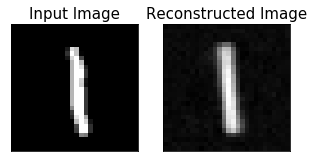

In [11]:
test_x, test_y = batch_maker(1, test_imgs, test_labels)
x_reconst = sess.run(reconst, feed_dict={x : test_x})

fig = plt.figure(figsize=(5, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(test_x.reshape(28, 28), 'gray')
ax1.set_title('Input Image', fontsize=15)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(x_reconst.reshape(28, 28), 'gray')
ax2.set_title('Reconstructed Image', fontsize=15)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

__ Test Distribution of Latent Variable __
- We project 784-dimensional image to 2-dimensional space

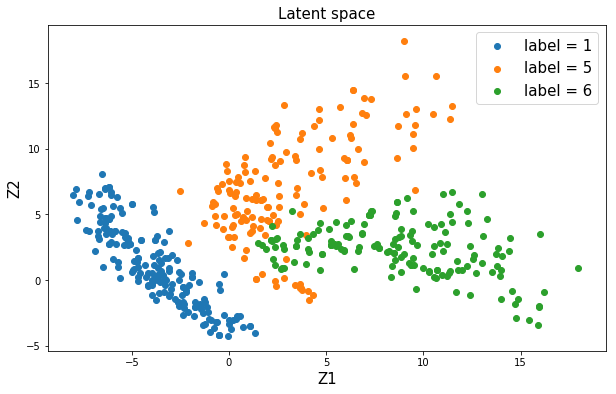

In [12]:
test_x, test_y = batch_maker(500, test_imgs, test_labels)
test_y = np.argmax(test_y, axis=1)
test_latent = sess.run(latent, feed_dict={x : test_x})

plt.figure(figsize=(10,6))
plt.scatter(test_latent[test_y == 1, 0], test_latent[test_y == 1, 1], label = 'label = 1')
plt.scatter(test_latent[test_y == 5, 0], test_latent[test_y == 5, 1], label = 'label = 5')
plt.scatter(test_latent[test_y == 6, 0], test_latent[test_y == 6, 1], label = 'label = 6')
plt.title('Latent space', fontsize=15)
plt.xlabel('Z1', fontsize=15)
plt.ylabel('Z2', fontsize=15)
plt.legend(fontsize = 15)
plt.show()

__ Data Generation __

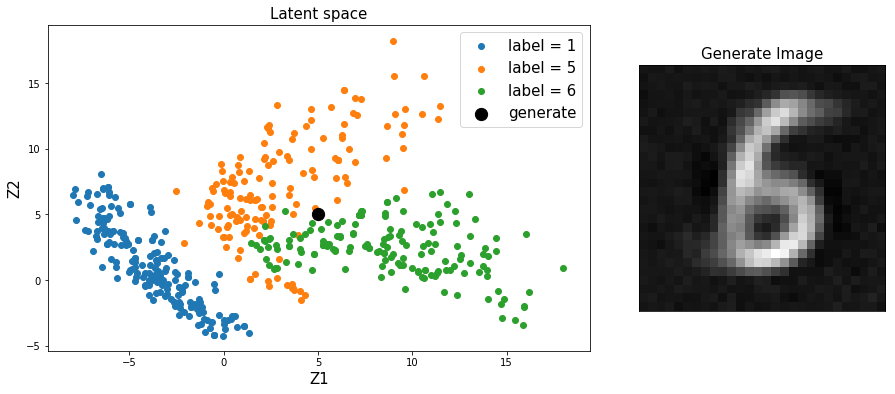

In [13]:
generate_data = np.array([[5.0, 5.0]])

fig = plt.figure(figsize=(15,6))
ax = plt.subplot2grid((1,3), (0,0), colspan=2)
ax.scatter(test_latent[test_y == 1, 0], test_latent[test_y == 1, 1], label = 'label = 1')
ax.scatter(test_latent[test_y == 5, 0], test_latent[test_y == 5, 1], label = 'label = 5')
ax.scatter(test_latent[test_y == 6, 0], test_latent[test_y == 6, 1], label = 'label = 6')
ax.scatter(generate_data[:, 0], generate_data[:, 1], label = 'generate', s = 150, c = 'k', marker = 'o')
ax.set_title('Latent space', fontsize=15)
ax.set_xlabel('Z1', fontsize=15)
ax.set_ylabel('Z2', fontsize=15)
ax.legend(fontsize = 15)

latent_input = tf.placeholder(tf.float32, [None, n_latent])
reconst = decoder(latent_input, weights, biases)
generate_x = sess.run(reconst, feed_dict={latent_input : generate_data})


ax = plt.subplot2grid((1,3), (0,2), colspan=1)
ax.imshow(generate_x.reshape(28, 28), 'gray')
ax.set_title('Generate Image', fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# 3. Visualization

__Image Generation__

- Select an arbitrary latent varibale $z$
- Generate images using the learned decoder

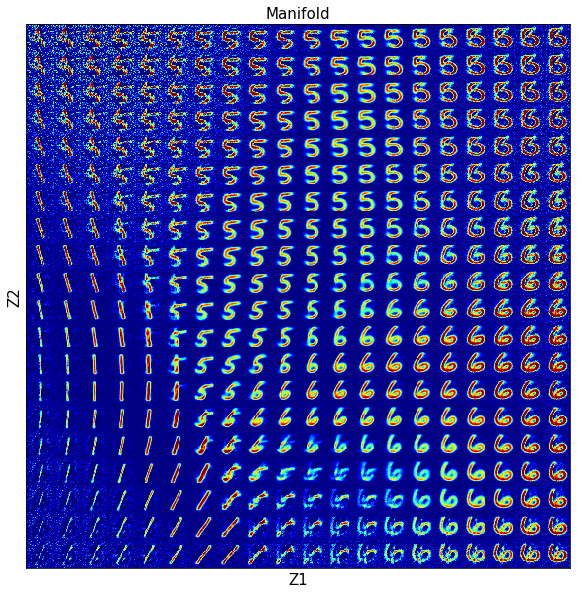

In [18]:
# Initialize canvas
nx = ny = 20
x_values = np.linspace(-5, 20, nx)
y_values = np.linspace(-10, 20, ny)
canvas = np.empty((28*ny, 28*nx))

# Define placeholder
latent_input = tf.placeholder(tf.float32, [None, n_latent])
reconst = decoder(latent_input, weights, biases)

for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            latent_ = np.array([[xi, yi]])
            reconst_ = sess.run(reconst, feed_dict={latent_input : latent_})
            canvas[(nx - i - 1)*28:(nx - i)*28, j*28:(j + 1)*28] = reconst_.reshape(28,28)

plt.figure(figsize=(10, 10))
plt.imshow(canvas, clim=(0,1), cmap=plt.cm.jet)
plt.title('Manifold', fontsize=15)
plt.xticks([])
plt.xlabel('Z1', fontsize=15)
plt.yticks([])
plt.ylabel('Z2', fontsize=15)
plt.show()

In [15]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>